In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

#패키지 불러오기

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [210, 210]

# 데이터 경로 변수
ROOT_PATH = 'C:/Users/Desk_Kang/Desktop/Aiffel/workplace/Iamgroww/DeepCV'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 25
EPOCHS = 25

print(ROOT_PATH)

C:/Users/Desk_Kang/Desktop/Aiffel/workplace/Iamgroww/DeepCV


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5232
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 ???로 나눕니다
train_size = math.floor(len(filenames)*0.7)
random.seed(750)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

3673
1575


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')
#정상 이미지 와 폐렴 이미지 경로 확인

Normal image path
C:\Users\Desk_Kang\Desktop\Aiffel\workplace\Iamgroww\DeepCV\chest_xray\train\PNEUMONIA\person1079_virus_1789.jpeg
Pneumonia image path
C:\Users\Desk_Kang\Desktop\Aiffel\workplace\Iamgroww\DeepCV\chest_xray\train\PNEUMONIA\person730_virus_1351.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 951
Pneumonia images count in training set: 2722


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
#mini-batch를 위한 작업

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 3673
Validating images count: 1575


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
#이미지 데이터는 사이즈가 제각각일 가능성이 높아 사이즈를 통일시키기 위함
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
#train/val 데이터 셋
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
#이미지 리사이즈 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (210, 210, 3)
Label:  True


In [13]:
#test 데이터 셋 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [15]:
#데이터 파이프라인
#shuffle 무작위 요소 선택
#repeat 여러번 데이터셋을 사용할 수 있게 만듬
#batch 배치사이즈에 맞게 데이터 나눔

def prepare_for_training(ds, shuffle_buffer_size=8500):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [16]:
# # 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10,10))
#     for n in range(BATCH_SIZE):
#         ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
#         plt.imshow(image_batch[n])
#         if label_batch[n]:
#             plt.title("PNEUMONIA")
#         else:
#             plt.title("NORMAL")
#         plt.axis("off")


# image_batch, label_batch = next(iter(train_ds))
# show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
#residual_block

def residual_block(input_layer, n_filters, stride=1):
    merge_input = input_layer

# if문에서 채널 사이즈가 동일한지 확인하고, 그렇지 않다면 1x1 conv 통해서 채널 사이즈 맞추기
    if input_layer.shape[-1] != n_filters:
        # n_filter로 채널 사이즈를 맞춰 준다.
        merge_input = tf.keras.layers.Conv2D(n_filters, (1,1), padding='same')(input_layer)
    
    # Conv2D layer
    conv1 = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same')(input_layer)
	
    # Batch Normalization
    batch1 = tf.keras.layers.BatchNormalization()(conv1)

    # ReLU
    x = tf.keras.layers.Activation('relu')(batch1)

    # Conv2D layer
    conv2 = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same')(x)

    # Batch Normalization
    batch2 = tf.keras.layers.BatchNormalization()(conv2)
        
    # Add를 통해서 skip connection을 구현하는 부분
    out_layer = tf.keras.layers.Add()([batch2, merge_input])
    out_layer = tf.keras.layers.Activation('relu')(out_layer)
 
    return out_layer

In [18]:
#Resnet18 모델

def Resnet18():
    input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1],3))

    # Conv2D layer
    conv0 = tf.keras.layers.Conv2D(64, (3,3), strides=2, padding='same')(input_layer)

    # Batch Normalization
    conv1 = tf.keras.layers.BatchNormalization()(conv0)

    # ReLU
    x = tf.keras.layers.Activation('relu')(conv1)

    # MaxPooling
    x = tf.keras.layers.MaxPooling2D((3,3), strides=2, padding='same')(x)

    num_blocks = [2, 2, 2, 2]
    filters = [64, 128, 256, 512]

    for stage in range(4):
        for _ in range(num_blocks[stage]):
            x = residual_block(x, filters[stage], stride=2 if stage > 0 and _ == 0 else 1 )
            # 첫번째 residual block에서 스트라이드 2 주고 그 이후는 stride 1 주기

    # GlobalAveragePooling2D
    x = tf.keras.layers.AveragePooling2D((7,7))(x)

    x = tf.keras.layers.Flatten()(x)

    # Dense
    x = tf.keras.layers.Dense(1000, activation='relu')(x)

    # Dense2
    x = tf.keras.layers.Dense(1000, activation='relu')(x)

    # Output
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=x)

    return model



In [19]:
#Normal 과 Pneumonia 데이터 불균형(normal 현저히 적음) 해소를 위함
#특정 클래스에 가중치를 다르게 부여
#전체 데이터 건수에 반비례하도록 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))


Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


In [20]:
model = Resnet18()

In [21]:
#라벨이 2개라 loss = binary_crossentropy
#optimizer = adam
#metircs = accuracy, precision, recall


METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 210, 210, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 105, 105, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 105, 105, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [23]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("pneu_resnet18_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

#callback 설정

In [24]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.005, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

#학습률 설정

In [25]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/25
146/146 [==============================] - 152s 691ms/step - loss: 10.6348 - accuracy: 0.5805 - precision: 0.7530 - recall: 0.6458 - val_loss: 16.8119 - val_accuracy: 0.6400 - val_precision: 0.7412 - val_recall: 0.7913 - lr: 0.0050
Epoch 2/25
146/146 [==============================] - 96s 661ms/step - loss: 0.5908 - accuracy: 0.7074 - precision: 0.8771 - recall: 0.7040 - val_loss: 2.3003 - val_accuracy: 0.7448 - val_precision: 0.7447 - val_recall: 0.9983 - lr: 0.0040
Epoch 3/25
146/146 [==============================] - 99s 678ms/step - loss: 0.2634 - accuracy: 0.8852 - precision: 0.9630 - recall: 0.8785 - val_loss: 0.3994 - val_accuracy: 0.8660 - val_precision: 0.8522 - val_recall: 0.9914 - lr: 0.0032
Epoch 4/25
146/146 [==============================] - 102s 699ms/step - loss: 0.2199 - accuracy: 0.9079 - precision: 0.9711 - recall: 0.9032 - val_loss: 0.3217 - val_accuracy: 0.8863 - val_precision: 0.8711 - val_recall: 0.9940 - lr: 0.0025
Epoch 5/25
146/146 [================

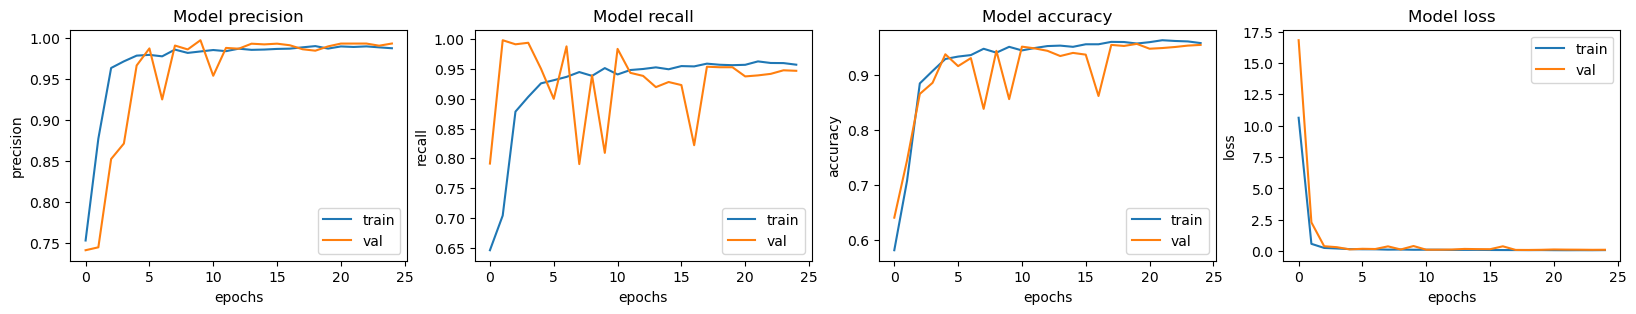

In [26]:
#성능 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
#평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

25/25 [==============================] - 5s 207ms/step - loss: 0.7801 - accuracy: 0.7821 - precision: 0.7520 - recall: 0.9718
Loss: 0.7801341414451599,
Accuracy: 0.7820512652397156,
Precision: 0.7519841194152832,
Recall: 0.971794843673706


In [28]:
#엥?